# Using USR to score dialogues

In [1]:
import sys
import os
import sys
import os
import json
import emissor as em
from emissor.persistence import ScenarioStorage
from emissor.representation.annotation import AnnotationType, Token, NER
from emissor.representation.container import Index
from emissor.representation.scenario import Modality, ImageSignal, TextSignal, Mention, Annotation, Scenario

src_path = os.path.abspath(os.path.join('..'))
if src_path not in sys.path:
    sys.path.append(src_path)

#### The next utils are needed for the interaction and creating triples and capsules
import chatbots.evaluation as eval
from chatbots.evaluation.dialogue_evaluation_likelihood import USR_MLM
from chatbots.evaluation.dialogue_evaluation_usr import USR_CTX

## Getting the dialogue from an EMISSOR scenario

In [2]:
def get_speaker_from_text_signal(textSignal:TextSignal):
    speaker = None
    mentions = textSignal.mentions
    for mention in mentions:
        annotations = mention.annotations
        for annotation in annotations:
            if annotation[0].type=="utterance":
                speaker = annotation[0].source
                break
        if speaker:
            break
    return speaker

In [3]:
def get_turns_with_context_from_signals(signals:[], max_context=200):
    quadruples = []
    speakers=set()
    context = ""
    target = ""
    cue =""
    for index, signal in enumerate(signals):
        speaker = get_speaker_from_text_signal(signal)
        if speaker:
            speakers.add(speaker)
        if index == 0:
            target = ''.join(signal.seq)
        else:
            cue = target
            context += " "+target
            target = ''.join(signal.seq)
        if len(context)>max_context:
            context = context[len(context)-max_context:]
        quadruple = (context, target, cue, speaker)
        quadruples.append(quadruple)
    return quadruples, speakers

In [4]:
scenario_path = "/Users/piek/PycharmProjects/cltl-chatbots/data"
### The name of your scenario
scenario_id = "2021-12-07-16:18:57"

max_context=300
### Create the scenario folder, the json files and a scenarioStorage and scenario in memory
scenarioStorage = ScenarioStorage(scenario_path)
scenario_ctrl = scenarioStorage.load_scenario(scenario_id)
signals = scenario_ctrl.get_signals(Modality.TEXT)
turns, speakers = get_turns_with_context_from_signals(signals, max_context)
print('Nr of turns:', len(turns), ' extracted from scenario: ', scenario_id)
print('Speakers:', speakers)
print('Max context:', max_context)

Nr of turns: 21  extracted from scenario:  2021-12-07-16:18:57
Speakers: {'Leolani2', 'Piek'}


## USR Masked Language Model scoring

We use the the Roberta model that was pretrained with the TopicalChat data by the USR team as a model for gettting the averaged token likelihood of the target sentence. The function *sentence_likelihood* also returns the most likley sentence according to the model and the averaged score for the mostly likely tokens. We can thus compare the actual response in a turn with the response that would be generated by the LM.

The LM will return a number of results for the masked token with probability scores. We compare the target token with the results to get the score for the target token. If the target token is not in the results, we set the probability to "0".

You can set the number of results returned by the model. The more results, the more likely the target gets a score, albeit a very low score.

In [5]:
top=20 ### this defines the number results returned by the LM for a masked token that we compare against
model_path_mlm = 'adamlin/usr-topicalchat-roberta_ft'
model_mlm = USR_MLM(path=model_path_mlm, top_results=top)

In [6]:
speaker_mlm_scores = {k: [] for k in speakers}
speaker_mlm_max_scores = {k: [] for k in speakers}
speaker_turns = {k: [] for k in speakers}

turn_index =[]
rows =[]
previous_speaker = None
for index, turn in enumerate(turns):
    turn_index.append(index)
    context = turn[0]
    target = turn[1]
    cue=turn[2]
    speaker=turn[3]
    llh, best_sentence, max_score = model_mlm.sentence_likelihood(context,target)
    row={"Turn": index, "Speaker": speaker, "Cue": cue, "Response": target, 
         "MLM response": best_sentence, "System llh":llh, "MLM llh": max_score}
    rows.append(row)

    if speaker:
        speaker_turns[speaker].append(index)
        speaker_mlm_scores[speaker].append(llh)
        speaker_mlm_max_scores[speaker].append(max_score)

### Visualising the dialogue quality

In [7]:
import numpy as np
import matplotlib.pyplot as plt

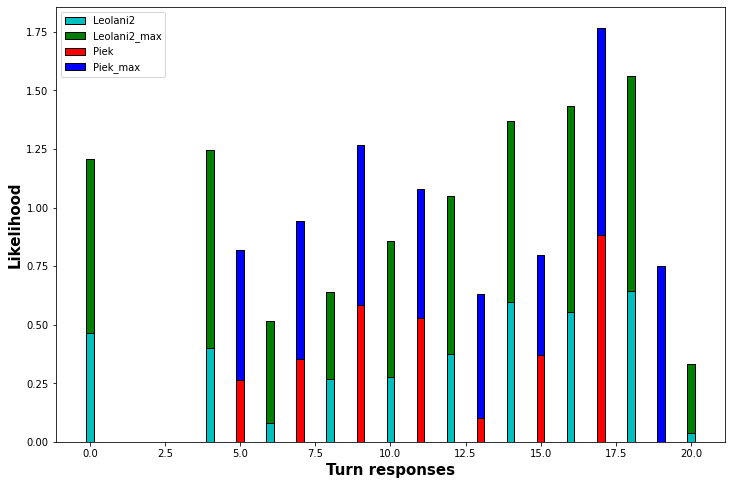

In [8]:
from random import getrandbits, choice
barWidth = 1/(len(speakers)*2)
fig = plt.subplots(figsize =(12, 8))
colors=["b","r","g","y","c", "m", "b"]
used_colors = []

###We take all turns from the turn_index to create the x-axis
x = np.arange(len(turn_index))

for speaker in speakers:
    ### picking a free colour
    c1 = choice(colors)
    c2 = choice(colors)
    while c1 in used_colors:
        c1 = choice(colors)
    used_colors.append(c1)
    while c2 in used_colors:
        c2 = choice(colors)
    used_colors.append(c2)

    #### each turn is is a response of a speaker to something, speaker may also be silent
    myturns = speaker_turns[speaker]
    
    ### We need align the scores turns with the turn_index so that we mix the speakers in a proper way
    ### get the scores and padd them with zeros for all turns not from speaker
    scores = speaker_mlm_scores[speaker]
    padded_scores = []
    for turn in turn_index:
        score = 0
        if turn in myturns:
            idx = myturns.index(turn)
            score = scores[idx] # get the corresponding score
        padded_scores.append(score)
    #print(padded_scores)
    
    #### we repeat this for the max score so that we can compare.
    max_scores = speaker_mlm_max_scores[speaker]
    padded_max_scores = []
    for turn in turn_index:
        score = 0
        if turn in myturns:
            idx = myturns.index(turn)
            score = max_scores[idx] # get the corresponding score
        padded_max_scores.append(score)
    #print(padded_max_scores)
    
    plt.bar(x, padded_scores,  color=c1, width=barWidth, edgecolor="black", label=speaker)
    plt.bar(x, padded_max_scores, bottom=padded_scores, color=c2, width=barWidth, edgecolor="black", label=speaker+"_max")
    

plt.xlabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.ylabel('Likelihood', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

## USR Context scoring

We first initiliase the models:

In [9]:
model_path = 'adamlin/usr-topicalchat-ctx'
model_ctx = USR_CTX(path=model_path)

model_path = 'adamlin/usr-topicalchat-uk'
model_uk = USR_CTX(path=model_path)

Some weights of the model checkpoint at adamlin/usr-topicalchat-ctx were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at adamlin/usr-topicalchat-uk were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model train

We now apply the models to get the scores and add these to the rows created before using the MLM. We also aggregate the scores for creating a dialogue graph. In this case we do not have a maximum score as a reference.

In [10]:
speaker_ctx_scores={k: [] for k in speakers}
speaker_uk_scores={k: [] for k in speakers}

for index, row in enumerate(rows):
    score_ctx = model_ctx.MCtx(row['Context'], row['System response'])
    score_uk = model_uk.MCtx(row['Context'], row['System response'])
    
    row['USR DLcontext']=score_ctx
    row['USR DLfact']=score_uk
    speaker = row["Speaker"]
    if speaker:
        speaker_ctx_scores[speaker].append(score_ctx)
        speaker_uk_scores[speaker].append(score_uk)


### Visualising the dialogue quality

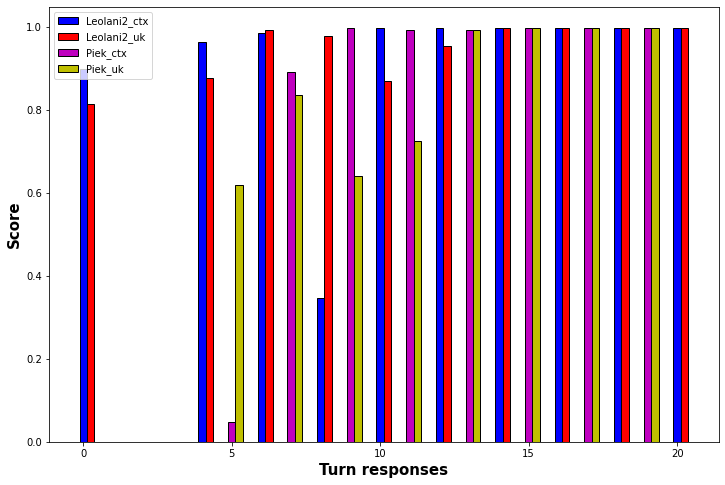

In [11]:
from random import getrandbits, choice
barWidth = 1/(len(speakers)*2)
fig = plt.subplots(figsize =(12, 8))
colors=["b","r","g","y","c", "m", "b"]
used_colors = []

###We take all turns from the turn_index to create the x-axis
x = np.arange(len(turn_index))

for speaker in speakers:
    ### picking a free colour
    c1 = choice(colors)
    c2 = choice(colors)
    while c1 in used_colors:
        c1 = choice(colors)
    used_colors.append(c1)
    while c2 in used_colors:
        c2 = choice(colors)
    used_colors.append(c2)

    #### each turn is is a response of a speaker to something, speaker may also be silent
    myturns = speaker_turns[speaker]
    
    ### We need align the scores turns with the turn_index so that we mix the speakers in a proper way
    ### get the scores and padd them with zeros for all turns not from speaker
    ctx_scores = speaker_ctx_scores[speaker]
    padded_ctx_scores = []
    for turn in turn_index:
        score = 0
        if turn in myturns:
            idx = myturns.index(turn)
            score = ctx_scores[idx] # get the corresponding score
        padded_ctx_scores.append(score)
    
    #### we repeat this for the max score so that we can compare.
    uk_scores = speaker_uk_scores[speaker]
    padded_uk_scores = []
    for turn in turn_index:
        score = 0
        if turn in myturns:
            idx = myturns.index(turn)
            score = uk_scores[idx] # get the corresponding score
        padded_uk_scores.append(score)
    
    plt.bar(x, padded_ctx_scores,  color=c1, width=barWidth, edgecolor="black", label=speaker+"_ctx")
    plt.bar(x+barWidth, padded_uk_scores, color=c2, width=barWidth, edgecolor="black", label=speaker+"_uk")
    

plt.xlabel('Turn responses', fontweight ='bold', fontsize = 15)
plt.ylabel('Score', fontweight ='bold', fontsize = 15)
plt.legend()
plt.show()

## Saving the results to CSV

In [12]:
annotation_columns = ["Overall Human Rating","Interesting","Engaging","Specific","Relevant","Correct","Semantically Appropriate","Understandable","Fluent"]

In [13]:
import pandas as pd
result_frame = pd.DataFrame(rows)
for annotation in annotation_columns:
    result_frame[annotation]=""
result_frame.head()

,Turn,Speaker,Cue,Context,System response,MLM response,System llh,MLM llh,USR DLcontext,USR DLfact,Overall Human Rating,Interesting,Engaging,Specific,Relevant,Correct,Semantically Appropriate,Understandable,Fluent
0,0,Leolani2,,,"How are you doing? I've told you my name, but ...",how are you ? i told you my story but...,0.462711,0.742430,0.898062,0.815380,,,,,,,,,
1,1,None,"How are you doing? I've told you my name, but ...","How are you doing? I've told you my name, but...",Piek,?,0.000000,0.127461,0.944033,0.795202,,,,,,,,,
2,2,None,Piek,"How are you doing? I've told you my name, but...",So your name is Piek?,? your name ? ?,0.277603,0.627130,0.994891,0.782008,,,,,,,,,
3,3,None,So your name is Piek?,"How are you doing? I've told you my name, but...",yes,!,0.000000,0.168669,0.915348,0.742947,,,,,,,,,
4,4,Leolani2,yes,"How are you doing? I've told you my name, but...","Tell me something, anything!",tell me about please,0.400313,0.845293,0.963688,0.876873,,,,,,,,,


In [14]:
file = scenario_id+"_turns"+str(len(turns))+"_context"+max_context+".csv"
result_frame.to_csv(file, index=False)

### Saving the overall scores

In [16]:
overall_rows = []
for speaker in speakers:
    turns = speaker_turns[speaker]
    mlm_scores = speaker_mlm_scores[speaker]   
    mlm_max_scores = speaker_mlm_max_scores[speaker]    
    ctx_scores = speaker_ctx_scores[speaker]   
    uk_scores = speaker_uk_scores[speaker]
    
    mlm_average_score = sum(mlm_scores)/len(mlm_scores)
    mlm_average_max_score = sum(mlm_max_scores)/len(mlm_max_scores)
    ctx_average_score = sum(ctx_scores)/len(ctx_scores)
    uk_average_score = sum(uk_scores)/len(uk_scores)
    overall_rows.append({'Speaker': speaker, 'Nr. turns': len(turns), 'MLM': mlm_average_score, 'MLM max': mlm_average_score, 'DLcontext': ctx_average_score, 'DLfact': uk_average_score})

overall_result_frame = pd.DataFrame(overall_rows)
overall_result_frame.head()
file = scenario_id+"_turns"+str(len(turns))+"_context"+max_context+"_overall.csv"
overall_result_frame.to_csv(file, index=False)


## End of notebook